In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent) if 'notebooks' in str(Path.cwd()) else str(Path.cwd()))

from src.db import attach_duckdb, load_sql, duckdb_to_df

In [2]:
### FETCH COHORT FROM REMOTE DB (WITH CHECKPOINT) ###

import pandas as pd
import os
from src.db import get_db, load_sql

print("Fetching Cohort...")
checkpoint_path = "/tmp/cohort_checkpoint.csv"

# Try to load from checkpoint if it exists
if os.path.exists(checkpoint_path):
    print(f"Loading cohort from checkpoint ({checkpoint_path})...")
    cohort_df = pd.read_csv(checkpoint_path)
else:
    try:
        db = get_db()
        db.attach_postgres(dbname="mimic")
        cohort_df = db.execute_query(load_sql("cohorts.sql"))
        
        # Save checkpoint for recovery
        cohort_df.to_csv(checkpoint_path, index=False)
        print(f"✓ Saved cohort checkpoint to {checkpoint_path}")
    except Exception as e:
        print(f"❌ Error loading cohort: {type(e).__name__}: {e}")

cohort_ids = tuple(cohort_df['hadm_id'].tolist())
print(f"✓ {len(cohort_ids)} patients in cohort")

Fetching Cohort...
Loading cohort from checkpoint (/tmp/cohort_checkpoint.csv)...
✓ 11726 patients in cohort


In [9]:
### FETCH FEATURES (OPTIMIZED SQL WITH TEMP TABLE) ###

import pandas as pd
import numpy as np
from src.db import get_db, load_sql

print("Fetching Features...")
print(f"Total cohort IDs: {len(cohort_ids)}")

try:
    db = get_db()
    db.attach_postgres(dbname="mimic")
    
    # Create temp table from cohort_ids (much faster than IN clause)
    print("Creating temporary table from cohort IDs...")
    cohort_ids_df = pd.DataFrame({'hadm_id': list(cohort_ids)})
    db.create_temp_table(cohort_ids_df, table_name='temp_cohort')
    
    # Optimized SQL using temp table join instead of IN clause
    optimized_query = """
    WITH cohort_filtered AS (
        SELECT DISTINCT
            adm.subject_id,
            adm.hadm_id,
            adm.admittime,
            CASE 
                WHEN adm.hospital_expire_flag = 1 THEN adm.deathtime
                ELSE adm.dischtime
            END AS end_time
        FROM mimic.mimiciv_hosp.admissions adm
        INNER JOIN temp_cohort tc ON adm.hadm_id = tc.hadm_id
    ),
    vitals_agg AS (
        SELECT 
            c.hadm_id,
            AVG(CASE WHEN v.charttime <= (c.admittime + INTERVAL 1 DAY) THEN v.heart_rate END) as hr_base,
            AVG(CASE WHEN v.charttime <= (c.admittime + INTERVAL 1 DAY) THEN v.mbp END) as map_base,
            AVG(CASE WHEN v.charttime >= (c.end_time - INTERVAL 1 DAY) THEN v.heart_rate END) as hr_end,
            AVG(CASE WHEN v.charttime >= (c.end_time - INTERVAL 1 DAY) THEN v.mbp END) as map_end
        FROM cohort_filtered c
        LEFT JOIN mimic.mimiciv_derived.vitalsign v 
            ON c.subject_id = v.subject_id
            AND v.charttime BETWEEN c.admittime AND c.end_time
        GROUP BY c.hadm_id
    ),
    labs_agg AS (
        SELECT 
            c.hadm_id,
            AVG(CASE WHEN l.charttime <= (c.admittime + INTERVAL 1 DAY) THEN l.creatinine END) as creat_base,
            AVG(CASE WHEN l.charttime <= (c.admittime + INTERVAL 1 DAY) THEN l.bun END) as bun_base,
            AVG(CASE WHEN cbc.charttime <= (c.admittime + INTERVAL 1 DAY) THEN cbc.wbc END) as wbc_base,
            AVG(CASE WHEN cbc.charttime <= (c.admittime + INTERVAL 1 DAY) THEN cbc.platelet END) as platelet_base,
            AVG(CASE WHEN bg.charttime <= (c.admittime + INTERVAL 1 DAY) THEN bg.lactate END) as lac_base,
            AVG(CASE WHEN l.charttime >= (c.end_time - INTERVAL 1 DAY) THEN l.creatinine END) as creat_end,
            AVG(CASE WHEN l.charttime >= (c.end_time - INTERVAL 1 DAY) THEN l.bun END) as bun_end,
            AVG(CASE WHEN cbc.charttime >= (c.end_time - INTERVAL 1 DAY) THEN cbc.wbc END) as wbc_end,
            AVG(CASE WHEN cbc.charttime >= (c.end_time - INTERVAL 1 DAY) THEN cbc.platelet END) as platelet_end,
            AVG(CASE WHEN bg.charttime >= (c.end_time - INTERVAL 1 DAY) THEN bg.lactate END) as lac_end
        FROM cohort_filtered c
        LEFT JOIN mimic.mimiciv_derived.chemistry l 
            ON c.subject_id = l.subject_id
            AND l.charttime BETWEEN c.admittime AND c.end_time
        LEFT JOIN mimic.mimiciv_derived.complete_blood_count cbc 
            ON c.subject_id = cbc.subject_id
            AND cbc.charttime BETWEEN c.admittime AND c.end_time
        LEFT JOIN mimic.mimiciv_derived.bg bg 
            ON c.subject_id = bg.subject_id
            AND bg.charttime BETWEEN c.admittime AND c.end_time
        GROUP BY c.hadm_id
    )
    SELECT 
        c.hadm_id,
        COALESCE(v.hr_base, 0) as hr_base,
        COALESCE(v.map_base, 0) as map_base,
        COALESCE(l.creat_base, 0) as creat_base,
        COALESCE(l.bun_base, 0) as bun_base,
        COALESCE(l.wbc_base, 0) as wbc_base,
        COALESCE(l.platelet_base, 0) as platelet_base,
        COALESCE(l.lac_base, 0) as lac_base,
        COALESCE(v.hr_end, 0) as hr_end,
        COALESCE(v.map_end, 0) as map_end,
        COALESCE(l.creat_end, 0) as creat_end,
        COALESCE(l.bun_end, 0) as bun_end,
        COALESCE(l.wbc_end, 0) as wbc_end,
        COALESCE(l.platelet_end, 0) as platelet_end,
        COALESCE(l.lac_end, 0) as lac_end
    FROM cohort_filtered c
    LEFT JOIN vitals_agg v ON c.hadm_id = v.hadm_id
    LEFT JOIN labs_agg l ON c.hadm_id = l.hadm_id
    """
    
    print("Executing optimized query...")
    features_df = db.execute_query(optimized_query)
    db.unregister_temp_table('temp_cohort')
    
    print(f"✓ Features DF fetched: {features_df.shape}")
    print(f"✓ Features memory: {features_df.memory_usage(deep=True).sum() / 1e6:.2f} MB")
    
except Exception as e:
    print(f"❌ Optimized query failed: {type(e).__name__}: {e}")

# Merge carefully
#print("Merging cohort + features...")
#full_data = pd.merge(cohort_df, features_df, on='hadm_id', how='inner')
#print(f"✓ Merged data shape: {full_data.shape}")

Fetching Features...
Total cohort IDs: 11726
❌ Error attaching PostgreSQL: BinderException: Binder Error: Failed to attach database: database with name "mimic" already exists
Creating temporary table from cohort IDs...
✓ Temporary table 'temp_cohort' created: (11726, 1)
Executing optimized query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Temporary table 'temp_cohort' unregistered
✓ Features DF fetched: (11726, 15)
✓ Features memory: 1.36 MB


In [19]:
checkpoint_path = "/tmp/features_checkpoint.csv"

features_df.to_csv(checkpoint_path, index=False)
print(f"✓ Saved features checkpoint to {checkpoint_path}")

✓ Saved features checkpoint to /tmp/features_checkpoint.csv


In [24]:
print((cohort_df['label'] == 1).sum())
print((cohort_df['label'] == 0).sum())

mortality = cohort_df['label'].value_counts(normalize=True)[1]
print(f"✓ Mortality rate in cohort: {mortality:.2%}")

184
11542
✓ Mortality rate in cohort: 1.57%


In [35]:
# Merge carefully
from numpy import full


print("Merging cohort + features...")
full_data = pd.merge(cohort_df, features_df, on='hadm_id', how='inner')
print(f"✓ Merged data shape: {full_data.shape}")

params = ['hr', 'map', 'creat', 'bun', 'wbc', 'platelet', 'lac']

Merging cohort + features...
✓ Merged data shape: (11726, 23)


In [36]:
# 5. Imputation (simple imputation for demo; use KNN or MICE for production)
for p in params:
    full_data[f'{p}_base'] = full_data[f'{p}_base'].fillna(full_data[f'{p}_base'].median())
    full_data[f'{p}_end'] = full_data[f'{p}_end'].fillna(full_data[f'{p}_end'].median())

# 6. Calculate Delta = Value_End - Value_Base
for p in params:
    full_data[f'{p}_delta'] = full_data[f'{p}_end'] - full_data[f'{p}_base']

# 7. Select Final Features for Model
feature_cols = [f'{p}_delta' for p in params] + [f'{p}_base' for p in params] + ['age', 'gender']

full_data['gender'] = full_data['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [41]:
print(full_data.head())
columns_to_drop = ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'end_time']

   label        age  gender    hr_base   map_base  creat_base  bun_base  \
0      0  65.035235       1  80.000000  75.250000         0.9      15.0   
1      0  53.351650       1   0.000000   0.000000         0.9      10.0   
2      0  85.973588       1   0.000000   0.000000         1.3      28.0   
3      0  52.558201       1   0.000000   0.000000         0.0       0.0   
4      0  75.320336       0  71.714286  75.428571         0.6      13.0   

    wbc_base  platelet_base  lac_base  ...  wbc_end  platelet_end  lac_end  \
0  18.233333     188.666667      1.35  ...     13.4         193.0      0.0   
1   7.500000     204.000000      1.20  ...      0.0           0.0      0.0   
2   9.000000     340.000000      0.00  ...     11.2         268.0      0.0   
3   0.000000       0.000000      0.00  ...      9.1         175.0      0.0   
4  14.450000     130.500000      1.45  ...      6.0         189.0      0.0   

    hr_delta  map_delta  creat_delta  bun_delta  wbc_delta  platelet_delta  \
0 

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = full_data[feature_cols].values
y = full_data['label'].values

# 8. Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
from src.model import CardiacDataset, MortalityPredictor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

train_dataset = CardiacDataset(X_train_scaled, y_train)
test_dataset = CardiacDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = MortalityPredictor(input_dim=X_train.shape[1])
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss/len(train_loader):.4f}")

Starting Training...
Epoch 1/20 | Loss: 0.2755
Epoch 2/20 | Loss: 0.0563
Epoch 3/20 | Loss: 0.0358
Epoch 4/20 | Loss: 0.0272
Epoch 5/20 | Loss: 0.0224
Epoch 6/20 | Loss: 0.0233
Epoch 7/20 | Loss: 0.0211
Epoch 8/20 | Loss: 0.0203
Epoch 9/20 | Loss: 0.0193
Epoch 10/20 | Loss: 0.0192
Epoch 11/20 | Loss: 0.0174
Epoch 12/20 | Loss: 0.0161
Epoch 13/20 | Loss: 0.0164
Epoch 14/20 | Loss: 0.0155
Epoch 15/20 | Loss: 0.0129
Epoch 16/20 | Loss: 0.0159
Epoch 17/20 | Loss: 0.0132
Epoch 18/20 | Loss: 0.0133
Epoch 19/20 | Loss: 0.0143
Epoch 20/20 | Loss: 0.0147



Model AUC-ROC: 0.9979
Optimal Threshold (Max F1): 0.1462

--- Clinical Performance Report (at Optimal Threshold) ---
              precision    recall  f1-score   support

    Survivor       1.00      1.00      1.00      2309
   Mortality       0.92      0.92      0.92        37

    accuracy                           1.00      2346
   macro avg       0.96      0.96      0.96      2346
weighted avg       1.00      1.00      1.00      2346



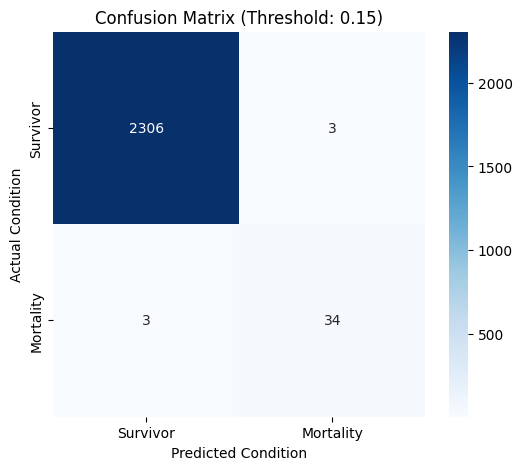


Brier Score (Calibration Error): 0.0031


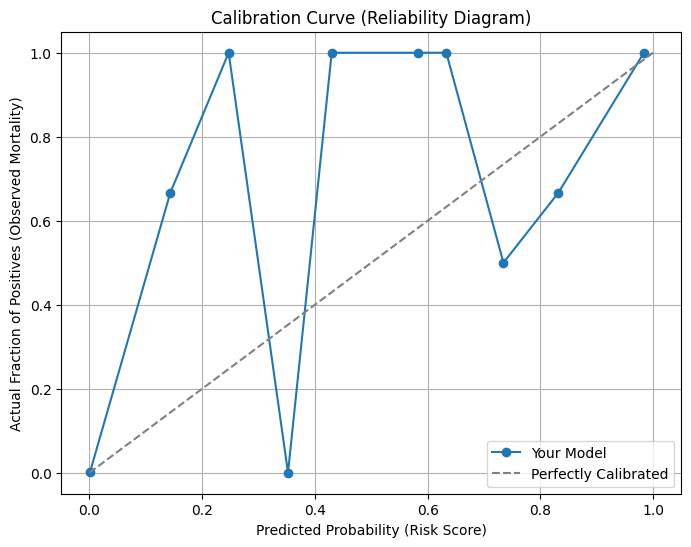

Sensitivity (Recall - Catching Deaths): 91.89%
Specificity (Avoid False Alarms): 99.87%


In [44]:
import numpy as np
from sklearn.metrics import (roc_auc_score, confusion_matrix, classification_report, 
                             roc_curve, precision_recall_curve, f1_score, 
                             auc, brier_score_loss)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_targets = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        all_preds.extend(y_pred.numpy())
        all_targets.extend(y_batch.numpy())

y_pred_probs = np.array(all_preds)
y_targets = np.array(all_targets)

# Calculate AUC
auc = roc_auc_score(y_targets, y_pred_probs)
print(f"\nModel AUC-ROC: {auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_targets, y_pred_probs)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8) # added epsilon to avoid div by 0
best_idx = np.argmax(f1_scores)

if best_idx < len(thresholds):
    best_threshold = thresholds[best_idx]
else:
    best_threshold = 0.5
print(f"Optimal Threshold (Max F1): {best_threshold:.4f}")

# Convert to binary predictions (Using optimal threshold)
y_pred_binary = (y_pred_probs > best_threshold).astype(int)

print("\n--- Clinical Performance Report (at Optimal Threshold) ---")
print(classification_report(y_targets, y_pred_binary, target_names=['Survivor', 'Mortality']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_targets, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survivor', 'Mortality'], 
            yticklabels=['Survivor', 'Mortality'])
plt.ylabel('Actual Condition')
plt.xlabel('Predicted Condition')
plt.title(f'Confusion Matrix (Threshold: {best_threshold:.2f})')
plt.show()

brier = brier_score_loss(y_targets, y_pred_probs)
print(f"\nBrier Score (Calibration Error): {brier:.4f}")

prob_true, prob_pred = calibration_curve(y_targets, y_pred_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability (Risk Score)')
plt.ylabel('Actual Fraction of Positives (Observed Mortality)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Sensitivity (Recall - Catching Deaths): {sensitivity:.2%}")
print(f"Specificity (Avoid False Alarms): {specificity:.2%}")
